In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(parent_dir)
from src.utils import calculate_eer


In [2]:
csv_path = os.path.join(parent_dir, 'data', 'scores', 'facenet_eval_front_base_scores.csv')
# csv_path = os.path.join(parent_dir, 'test.csv')

In [3]:
data = pd.read_csv(csv_path)

In [4]:
results_json = {}

Text(0.5, 1.0, 'facenet - same (1) and different (0) people embeddings similarity')

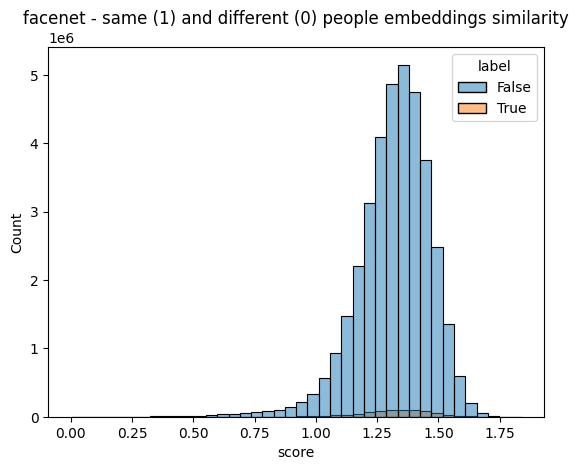

In [5]:
sns.histplot(data = data, x = 'score', hue='label',bins = 40)
plt.title('facenet - same (1) and different (0) people embeddings similarity')

In [6]:
same_person = data[data['label'] == 1]
diff_person = data[data['label'] == 0]

In [7]:
print(f"Same person mean: {same_person['score'].mean()}")
print(f'Same person std: {same_person["score"].std()}')
print(f"Diff person mean: {diff_person['score'].mean()}")
print(f'Diff person std: {diff_person["score"].std()}')

Same person mean: 1.3204894363612243
Same person std: 0.14775339974856275
Diff person mean: 1.3184994459681894
Diff person std: 0.14875518393918885


In [8]:
results_json['eval'] = {}
results_json['eval']['similarity_distribution'] = {}

In [9]:
results_json['eval']['similarity_distribution']['same_person_mean'] = round(same_person['score'].mean(), 6)
results_json['eval']['similarity_distribution']['same_person_std'] = round(same_person['score'].std(), 6)
results_json['eval']['similarity_distribution']['diff_person_mean'] = round(diff_person['score'].mean(), 6)
results_json['eval']['similarity_distribution']['diff_person_std'] = round(diff_person['score'].std(), 6)

In [10]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 1.320489,
   'same_person_std': 0.147753,
   'diff_person_mean': 1.318499,
   'diff_person_std': 0.148755}}}

In [11]:
thresholds = np.linspace(0, 1.8, 181)

In [12]:
accs = []
f1s = []
precs = []
recs = []
fars = []
frrs = []

In [13]:
ground_truth = data['label']
for t in thresholds:
    decisions = data['score'] < t
    acc = accuracy_score(ground_truth, decisions)
    f1 = f1_score(ground_truth, decisions)
    prec = precision_score(ground_truth, decisions)
    rec = recall_score(ground_truth, decisions)
    FP = np.sum((ground_truth == 0) & (decisions == 1))
    FN = np.sum((ground_truth == 1) & (decisions == 0))
    TP = np.sum((ground_truth == 1) & (decisions == 1))
    TN = np.sum((ground_truth == 0) & (decisions == 0))
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    fars.append(FAR)
    frrs.append(FRR)
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    

d:\Projekt\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
threshold, eer = calculate_eer(thresholds, fars, frrs)

In [15]:
print(threshold, eer)

1.3343437052120015 0.5026122748556843


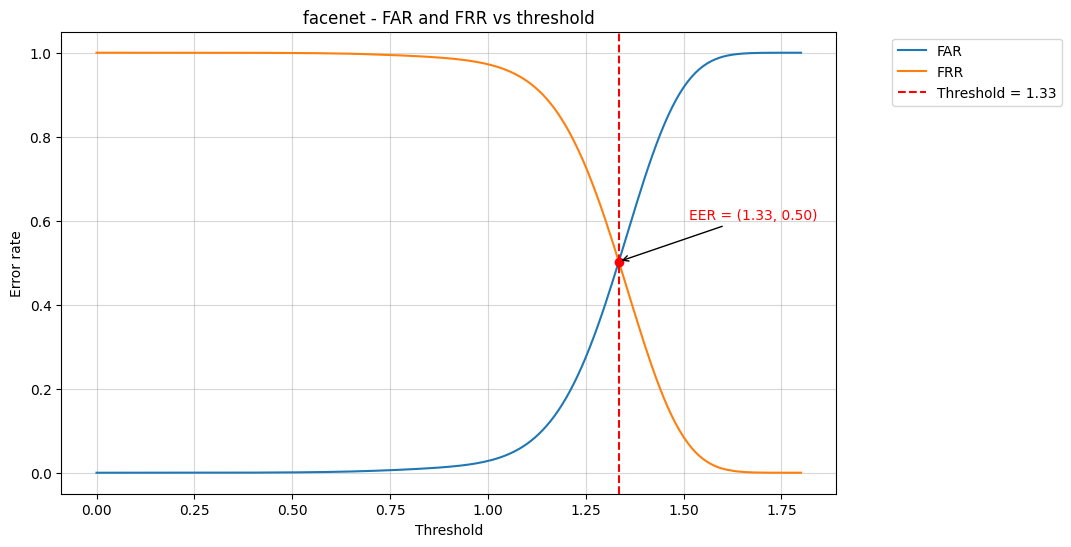

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fars, label='FAR')
plt.plot(thresholds, frrs, label='FRR')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.scatter(threshold, eer, color='red', zorder=2)
plt.annotate(
    f'EER = ({threshold:.2f}, {eer:.2f})', 
    xy=(threshold, eer), 
    xytext=(threshold + np.max(thresholds)/10, eer + 0.1),  # Adjust text position
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    color='red'
)
plt.title('facenet - FAR and FRR vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.grid(alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

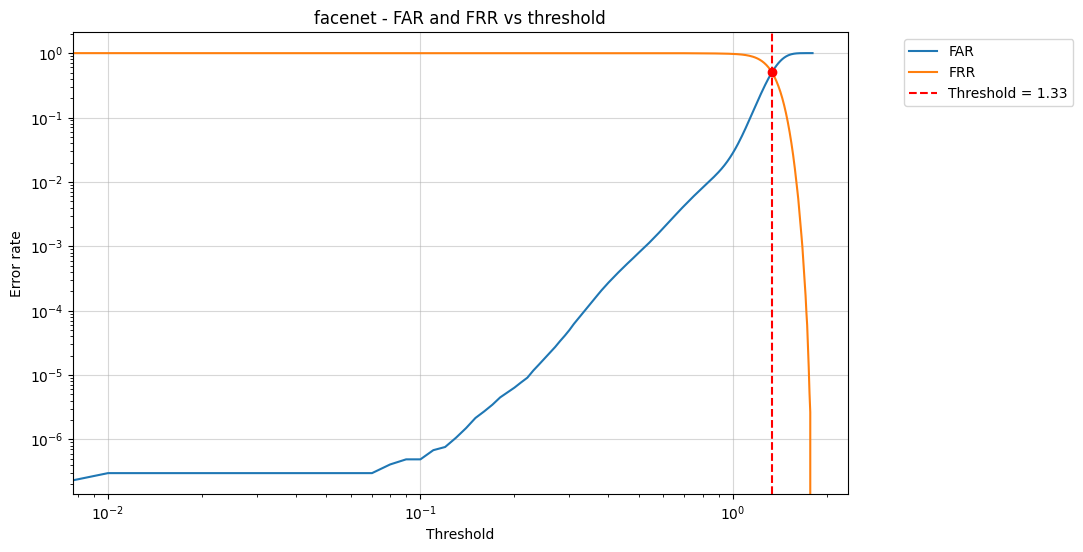

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fars, label='FAR')
plt.plot(thresholds, frrs, label='FRR')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.scatter(threshold, eer, color='red', zorder=2)
plt.title('facenet - FAR and FRR vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

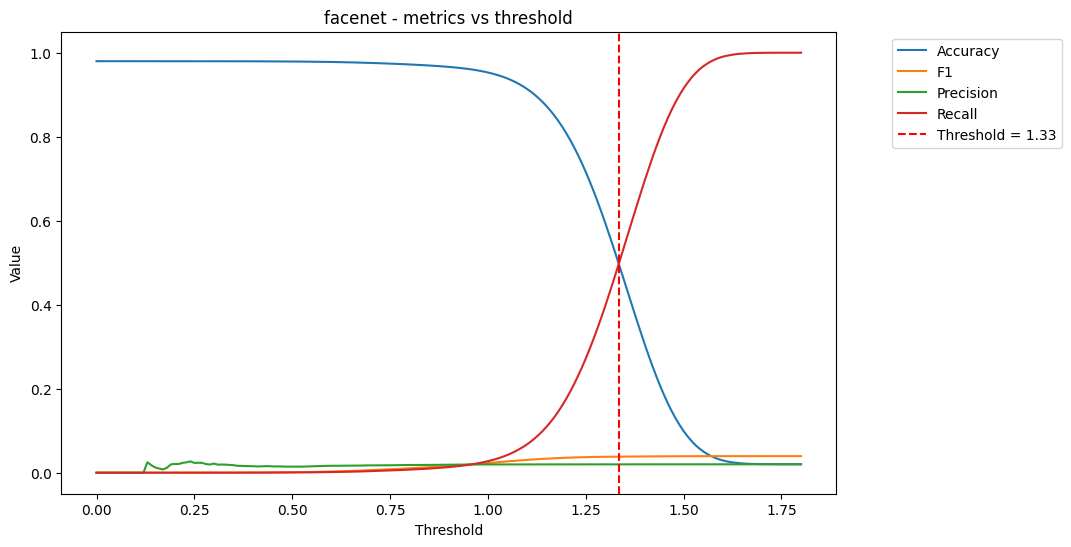

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accs, label='Accuracy')
plt.plot(thresholds, f1s, label='F1')
plt.plot(thresholds, precs, label='Precision')
plt.plot(thresholds, recs, label='Recall')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('facenet - metrics vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [19]:
decisions = data['score'] < threshold
acc = accuracy_score(ground_truth, decisions)
f1 = f1_score(ground_truth, decisions)
prec = precision_score(ground_truth, decisions)
rec = recall_score(ground_truth, decisions)
FP = np.sum((ground_truth == 0) & (decisions == 1))
FN = np.sum((ground_truth == 1) & (decisions == 0))
TP = np.sum((ground_truth == 1) & (decisions == 1))
TN = np.sum((ground_truth == 0) & (decisions == 0))
FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(f'Accuracy: {round(acc, 5)}')
print(f'F1: {round(f1, 5)}')
print(f'Precision: {round(prec, 5)}')
print(f'Recall: {round(rec, 5)}')
print(f'FAR: {round(FAR, 7)}')
print(f'FRR: {round(FRR, 5)}')

Accuracy: 0.49742
F1: 0.03831
Precision: 0.01992
Recall: 0.49728
FAR: 0.5025748
FRR: 0.50272


In [20]:
results_json 

{'eval': {'similarity_distribution': {'same_person_mean': 1.320489,
   'same_person_std': 0.147753,
   'diff_person_mean': 1.318499,
   'diff_person_std': 0.148755}}}

In [21]:
results_json['eval']['metrics'] = {}
results_json['eval']['metrics']['accuracy'] = round(acc, 6)
results_json['eval']['metrics']['f1'] = round(f1, 6)
results_json['eval']['metrics']['precision'] = round(prec, 6)
results_json['eval']['metrics']['recall'] = round(rec, 6)
results_json['eval']['metrics']['far'] = round(FAR, 6)
results_json['eval']['metrics']['frr'] = round(FRR, 6)
results_json['eval']['metrics']['eer'] = round(eer, 6)
results_json['eval']['threshold'] = round(threshold, 6)

In [22]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 1.320489,
   'same_person_std': 0.147753,
   'diff_person_mean': 1.318499,
   'diff_person_std': 0.148755},
  'metrics': {'accuracy': 0.497422,
   'f1': 0.038313,
   'precision': 0.019924,
   'recall': 0.497279,
   'far': 0.502575,
   'frr': 0.502721,
   'eer': 0.502612},
  'threshold': 1.334344}}

## Test

In [23]:
csv_path = os.path.join(parent_dir, 'data', 'scores', 'facenet_test_front_base_scores.csv')
data = pd.read_csv(csv_path)

In [24]:
ground_truth = data['label']

In [25]:
decisions = data['score'] < threshold
acc = accuracy_score(ground_truth, decisions)
f1 = f1_score(ground_truth, decisions)
prec = precision_score(ground_truth, decisions)
rec = recall_score(ground_truth, decisions)
FP = np.sum((ground_truth == 0) & (decisions == 1))
FN = np.sum((ground_truth == 1) & (decisions == 0))
TP = np.sum((ground_truth == 1) & (decisions == 1))
TN = np.sum((ground_truth == 0) & (decisions == 0))
FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(f'Accuracy: {round(acc, 5)}')
print(f'F1: {round(f1, 5)}')
print(f'Precision: {round(prec, 5)}')
print(f'Recall: {round(rec, 5)}')
print(f'FAR: {round(FAR, 7)}')
print(f'FRR: {round(FRR, 5)}')

Accuracy: 0.53743
F1: 0.03818
Precision: 0.01992
Recall: 0.45623
FAR: 0.4609041
FRR: 0.54377


In [26]:
results_json['test'] = {}
results_json['test']['metrics'] = {}
results_json['test']['metrics']['accuracy'] = round(acc, 6)
results_json['test']['metrics']['f1'] = round(f1, 6)
results_json['test']['metrics']['precision'] = round(prec, 6)
results_json['test']['metrics']['recall'] = round(rec, 6)
results_json['test']['metrics']['far'] = round(FAR, 6)
results_json['test']['metrics']['frr'] = round(FRR, 6)

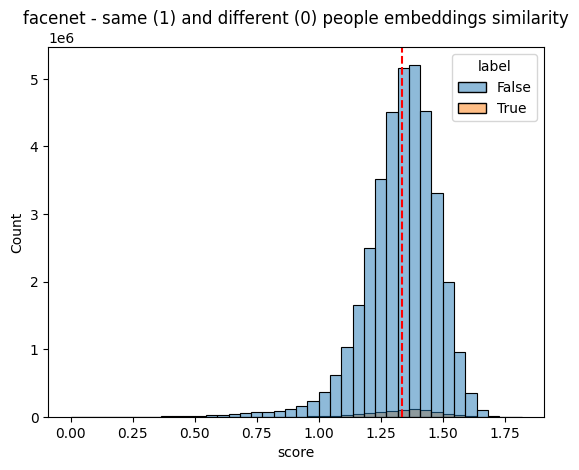

In [27]:
sns.histplot(data = data, x = 'score', hue='label',bins = 40)
plt.title('facenet - same (1) and different (0) people embeddings similarity')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')

In [28]:
same_person = data[data['label'] == 1]
diff_person = data[data['label'] == 0]

In [29]:
results_json['test']['similarity_distribution'] = {}

In [30]:
results_json['test']['similarity_distribution']['same_person_mean'] = round(same_person['score'].mean(), 6)
results_json['test']['similarity_distribution']['same_person_std'] = round(same_person['score'].std(), 6)
results_json['test']['similarity_distribution']['diff_person_mean'] = round(diff_person['score'].mean(), 6)
results_json['test']['similarity_distribution']['diff_person_std'] = round(diff_person['score'].std(), 6)

In [31]:
fars=[]
frrs=[]
ground_truth = data['label']
for t in thresholds:
    decisions = data['score'] < t
    FP = np.sum((ground_truth == 0) & (decisions == 1))
    FN = np.sum((ground_truth == 1) & (decisions == 0))
    TP = np.sum((ground_truth == 1) & (decisions == 1))
    TN = np.sum((ground_truth == 0) & (decisions == 0))
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    fars.append(FAR)
    frrs.append(FRR)


In [32]:
_, eer = calculate_eer(thresholds, fars, frrs)

In [33]:
results_json['test']['metrics']['eer'] = round(eer, 6)

In [34]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 1.320489,
   'same_person_std': 0.147753,
   'diff_person_mean': 1.318499,
   'diff_person_std': 0.148755},
  'metrics': {'accuracy': 0.497422,
   'f1': 0.038313,
   'precision': 0.019924,
   'recall': 0.497279,
   'far': 0.502575,
   'frr': 0.502721,
   'eer': 0.502612},
  'threshold': 1.334344},
 'test': {'metrics': {'accuracy': 0.537429,
   'f1': 0.038176,
   'precision': 0.019921,
   'recall': 0.456232,
   'far': 0.460904,
   'frr': 0.543768,
   'eer': 0.502239},
  'similarity_distribution': {'same_person_mean': 1.333055,
   'same_person_std': 0.143879,
   'diff_person_mean': 1.331713,
   'diff_person_std': 0.145229}}}

In [35]:
import json
with open(f"{parent_dir}/results/facenet_front.json", "w") as outfile:
    json.dump(results_json, outfile)